# DarkELF multiphonon notebook

This notebook is meant to illustrate the part of the darkELF package for calculating dark matter-phonon rates in the multiphonon regime.

written by Ethan, updated 03/07/2021

In [1]:
%matplotlib inline

import sys, os
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pandas
from scipy import interpolate

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

# load the package
from darkelf import darkelf, targets

## Load the materials

When loading the materials, the "dos_filename" flag specifies the density of states that is being used for the calculation. It must be set in order to calculate rates in the multiphonon regime. DarkELF comes with one or more tabulated DOS files for each material. The user can add their own by simply adding the tabulated DOS to the folder of the material in question. In polyatomic materials, sometimes the partial density of states is provided for each atom. In this case, the "dos_filename" flag accepts a list of filenames, one for each partial density of states. (See GaAs example below.)


The multiphonon rate is computed with pretabulated auxiliary functions "Fn", to increase the computation speed. The default "Fn" functions are calculated for the default density of states provided with darkELF. If using your own density of states, you must first run the "create_Fn_omega()" function on the desired density of states to recompute these pretabulated functions.

In [2]:
targets.files('GaAs')

Available configuration files: 
	 GaAs.yaml
 
Available data for epsilon: 
	 GaAs_mermin.dat
	 Ga_pDOS.dat
	 Ga_atomic_Zion.dat
	 As_pDOS.dat
	 As_atomic_Zion.dat
	 GaAs_epsphonon_data10K.dat
 
Available data for phonon density of states: 
 
Available data for phonon partial density of states: 
 
Available data for Fn(omega) functions: 
	 As_Fn.dat
	 Ga_Fn.dat
 
Available data for form factors: 


This is referring to the effective charge right?

If one is only interested in the multiphonon response, the electronic response specified with the "filename" flag is not used. If it is not specified, the code will produce a warning message, as seen below. There's also an optional form_factor_filename if one is interested in using a custom DM-atomic form factor. These can be ignored as long as we only care about DM-multiphonon scattering. Let's load a few materials.

In [3]:
gaas = darkelf(target='GaAs',dos_filename=["Ga_pDoS.dat","As_pDoS.dat"])
print("------")
si = darkelf(target='Si',dos_filename="Si_DoS.dat")
print("------")

 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename to perform data-driven, single phonon calculations
Warning! Atomic Migdal calculation not present
Warning! Momentum Zion not loaded. Using Z - number of valence electrons.
Loaded Ga_atomic_Zion.dat and As_atomic_Zion.dat for effective charges
Loaded Ga_pDoS.dat and As_pDoS.dat for partial densities of states
Loaded Fn(omega) functions corresponding to density of states in:  Ga_pDoS.dat   As_pDoS.dat
------
 .... Loading files for Si
Loaded Si_gpaw_withLFE.dat for epsilon in electron regime
electronic ELF taken or calculated from J. Enkovaara et al.,Electronic structure calculations with GPAW: a real-space implementation of the projec

# Cross section plots

Now using the sigma_nucleon function to calculate the required DM-nucleon cross-section for a rate of 3 events/kg/yr

In [4]:
?gaas.sigma_multiphonons

Points 0 to 4 took 9.368507862091064 seconds to calculate
Points 5 to 9 took 18.032849073410034 seconds to calculate
Points 10 to 14 took 28.68356704711914 seconds to calculate
Points 15 to 19 took 39.3555109500885 seconds to calculate
Points 20 to 24 took 39.32721781730652 seconds to calculate
Points 25 to 29 took 46.504987955093384 seconds to calculate
Points 30 to 34 took 49.13956689834595 seconds to calculate
Points 35 to 39 took 44.33746790885925 seconds to calculate


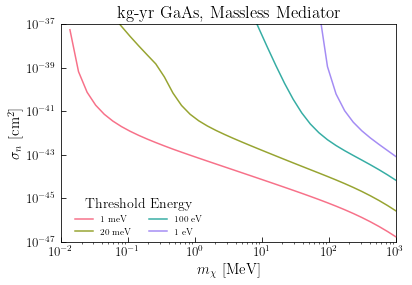

In [5]:
import seaborn as sns

points = 40

mdm = np.logspace(4, 9, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)
reaches4 = np.zeros(points)

import time

for i, mass in enumerate(mdm):
    gaas.update_params(mX = mass, mMed = 0) # update the DM mass
    if (i % 5) == 0:
        start = time.time()
    reaches1[i] = gaas.sigma_multiphonons(threshold=1e-3)
    reaches2[i] = gaas.sigma_multiphonons(threshold=20e-3)
    reaches3[i] = gaas.sigma_multiphonons(threshold=1e-1)
    reaches4[i] = gaas.sigma_multiphonons(threshold=1)

    if (i % 5) == 4:
        end = time.time()
        print(f'Points {i - 4} to {i} took {end - start} seconds to calculate')
        # Just to check that everything is still working
        
colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()


ax.plot(mdm/1e6, reaches1, label='$1$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$20$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$100$ eV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel('$\sigma_n \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

ax.set_title(r'kg-yr GaAs, Massless Mediator')

ax.set_xlim([1e-2,1e3])
ax.set_ylim([1e-47,1e-37])

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-47,-36,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.legend(loc=(0.03,0.01),fontsize=9,frameon=False,ncol=2,title='Threshold Energy')

plt.savefig(plotdir+"gaas_massless_multiphonon.pdf",bbox_inches='tight')


If starting with a new density of states, one must run the 'create_Fn_omega()' function. (see below.) This defaults to creating the Fn functions corresponding to the density of states (or list of partial density of states) loaded in in the instantiation of the class. This can take an hour or more. 

# Differential Rate $\frac{dR}{d\omega}$

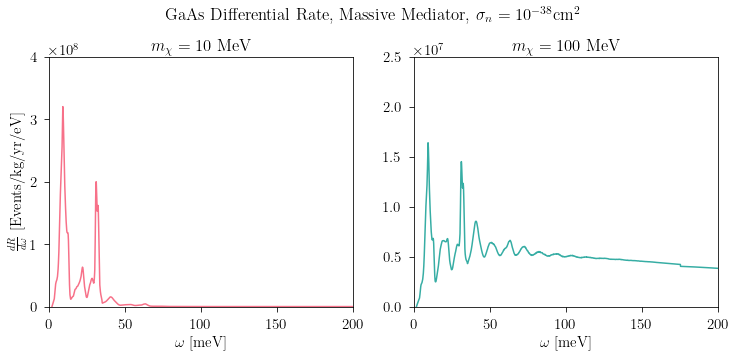

In [6]:
import seaborn as sns

omegarange = np.linspace(1e-4, 200e-3, 2000)

gaas.update_params(mX = 1e7, mMed = 1e9) # update the DM mass

dr_domega1 = [gaas._dR_domega_multiphonons_no_single(omega) for omega in omegarange]

gaas.update_params(mX = 1e8, mMed = 1e9) # update the DM mass

dr_domega2 = [gaas._dR_domega_multiphonons_no_single(omega) for omega in omegarange]

colors = sns.color_palette("husl", 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.6))

ax1.plot(omegarange*1e3, dr_domega1, color=colors[0])
ax2.plot(omegarange*1e3, dr_domega2, color=colors[1])


ax1.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax2.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax1.set_ylabel(r'$\frac{dR}{d\omega} \ [\mathrm{Events}/\mathrm{kg}/\mathrm{yr}/\mathrm{eV}]$',fontsize=15)


ax1.set_title(r'$m_\chi = 10$ MeV')
ax2.set_title(r'$m_\chi = 100$ MeV')

ax1.set_xlim([0,200])
ax2.set_xlim([0,200])

ax1.set_ylim([0,4e8])
ax2.set_ylim([0,2.5e7])


xtick_major = [50*n for n in range(5)]
ytick_major = [1e8*n for n in range(5)]
ax1.set_yticks(ytick_major)

ax1.set_xticks(xtick_major)
ax2.set_xticks(xtick_major)

ytick_major = [0.5e7*n for n in range(6)]
ax2.set_yticks(ytick_major)

plt.suptitle(r'GaAs Differential Rate, Massive Mediator, $\sigma_n = 10^{-38} \mathrm{cm}^2$', y=1.03)

plt.savefig(plotdir+"gaas_massive_rates.pdf",bbox_inches='tight')

In [7]:
npoints = 1000
threshold=0.01
sigman=1e-38
omegarange = np.logspace(np.log10(threshold), np.log10((1/2)*gaas.mX*(gaas.vmax)**2), npoints)

dr_domega = [gaas._dR_domega_multiphonons_no_single(omega, sigman=sigman, dark_photon=False) for omega in omegarange]
print(np.trapz(dr_domega, omegarange))

npoints = 10000
threshold=0.01
sigman=1e-38
omegarange = np.logspace(np.log10(threshold), np.log10((1/2)*gaas.mX*(gaas.vmax)**2), npoints)

dr_domega = [gaas._dR_domega_multiphonons_no_single(omega, sigman=sigman, dark_photon=False) for omega in omegarange]
ethanres=np.trapz(dr_domega, omegarange)

2034194.4744109595


In [8]:
gaas.R_multiphonons_no_single(threshold=0.01,sigman=sigman, dark_photon=False)

2034544.4764394893

In [9]:
threshold=0.01
sigman=1e-38

def test_convergence(npoints):
    omegarange = np.linspace(np.log10(threshold), 0.1, npoints)
    dr_domega = [gaas._dR_domega_multiphonons_no_single(omega, sigman=sigman, dark_photon=False) for omega in omegarange]
    intlow=np.trapz(dr_domega, omegarange)

    omegarange = np.logspace(-1, np.log10((1/2)*gaas.mX*(gaas.vmax)**2), npoints)
    dr_domega = [gaas._dR_domega_multiphonons_no_single(omega, sigman=sigman, dark_photon=False) for omega in omegarange]
    inthigh=np.trapz(dr_domega, omegarange)

    return intlow+inthigh

nplist=[100,300,1000,2500,5000,7500,10000]
convtest=list(map(test_convergence,nplist))

# Custom Momentum-dependent coupling (Dark Photon)

Here we calculate the cross-section for a rate of 3 events/kg/yr for a dark photon, using custom atomic couplings. In order to do this, the form factor must be loaded in at the instantiation of the class via 'fd_filename' (multiple filenames if multiple atoms) and the flag 'dark_photon' must be set to 'True' in function calls. Note that the default coupling without a custom coupling is the mass number.

Our effective charge here is valid for processes dominated by large momenta (massive mediator or $\geq2$-phonon calculations.

 .... Loading files for Si
Loaded Si_gpaw_withLFE.dat for epsilon in electron regime
electronic ELF taken or calculated from J. Enkovaara et al.,Electronic structure calculations with GPAW: a real-space implementation of the projector augmented-wave method,Journal of Physics:Condensed Matter22(2010) 253202.
Warning! eps for phonon frequencies not loaded. Need to set phonon_filename to perform data-driven, single phonon calculations
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000
Loaded Si_atomic_Zion.dat for dark photon couplings
Loaded Si_DoS.dat for density of states
Loaded Fn(omega) functions corresponding to density of states in:  Si_DoS.dat
Points 0 to 4 took 11.273770809173584 seconds to calculate
P

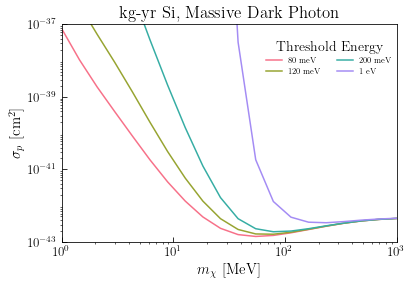

In [10]:
import seaborn as sns

# Loads dark photon form factor 
si = darkelf(target='Si',dos_filename="Si_DoS.dat",
             fd_filename='Si_atomic_Zion.dat')

points = 20

mdm = np.logspace(6, 9, points)

(reaches1, reaches2, reaches3, reaches4) = (np.zeros(points),np.zeros(points),np.zeros(points),np.zeros(points))

import time

for i, mass in enumerate(mdm):
    si.update_params(mX = mass, mMed = 1e10) # update the DM mass
    if (i % 5) == 0:
        start = time.time()
    reaches1[i] = si.sigma_multiphonons(80e-3, dark_photon=True)
    reaches2[i] = si.sigma_multiphonons(120e-3, dark_photon=True)
    reaches3[i] = si.sigma_multiphonons(200e-3, dark_photon=True)
    reaches4[i] = si.sigma_multiphonons(1000e-3, dark_photon=True)


    if (i % 5) == 4:
        end = time.time()
        print(f'Points {i - 4} to {i} took {end - start} seconds to calculate')
        # Just to check that everything is still working
        
colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()

ax.plot(mdm/1e6, reaches1, label='$80$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$120$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$200$ meV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1e0,1e3])
ax.set_ylim([1e-43,1e-37])

ax.set_xlabel('$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel('$\sigma_p \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

xtick_major = [pow(10.,n) for n in range(0,4,1)]
ytick_major = [pow(10.,n) for n in range(-43,-36,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.set_title(r'kg-yr Si, Massive Dark Photon')

ax.legend(loc=(0.60,0.75),fontsize=8,frameon=False,ncol=2,title="Threshold Energy",)

plt.savefig(plotdir+"si_massive_dark_photon.pdf",bbox_inches='tight')


## Using a user-supplied DOS table

The user can update the pretabulated function with their own density of states, using the "create_Fn_omega" function. This is rather slow and should be avoided if possible. At the end of this process, a the output will be stored in as a look-up table in a new "Fn" file, for future usage. The name of the Fn files is based on the name of the DoS files. For example


GaAs_DoS.dat --> GaAs_Fn.dat

Ga_pDoS.dat --> Ga_Fn.dat

As_pDoS.dat --> As_Fn.dat
 
etc. In other words, if the user supplies their own density of states

newfile_DoS.dat or newfile_pDoS.dat

"create_Fn_omega" will produce respectively

"newfile_Fn.dat" and "newfile_Fn.dat". 

It is important that the filenames of all user-supplied DOS or partial DOS files ends with "_DoS.dat" or "_pDoS.dat" respectively. When running the code, it suffices to specify the desired DOS file(s) with the "dos_filename" flag in the constructor. DarkELF will then automatically load in the corresponding Fn-tables, or calculate them if needed.  

In [11]:
gaas.create_Fn_omega(npoints=750)

Finished point #50 out of 750 for 2 phonons
Finished point #100 out of 750 for 2 phonons


KeyboardInterrupt: 